<a href="https://colab.research.google.com/github/monimoyd/S7/blob/master/S7_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S7
In this assignment I have trainded CIPHAR10 dataset. I have developed APIs so as to load data, train, test and show results.

I have used the network architecture C1-C2-C3-C4 with dilated kernel used in first layer of C2 and depthwise convolution used in first layer of C3. Total of 3 maxpooling is used after each of C1, C2, C3. Final layer uses GAP. Final RF is 122

In [0]:
%matplotlib inline

## Mount the google drive

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [0]:
!cp '/content/drive/My Drive/eva4_apis/model.py' .
!cp '/content/drive/My Drive/eva4_apis/train_test.py' .
!cp '/content/drive/My Drive/eva4_apis/accuracy_utils.py' .
!cp '/content/drive/My Drive/eva4_apis/data_loader.py' .
!cp '/content/drive/My Drive/eva4_apis/plot_metrics.py' .
!cp '/content/drive/My Drive/eva4_apis/data_transform.py' .

## Import all the libraries

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from model import Net
from train_test import train, test
from data_transform import get_transform
from data_loader import get_train_loader, get_test_loader, get_classes
from accuracy_utils import get_test_accuracy,get_accuracy_per_class
from plot_metrics import plot_loss_accuracy


Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [6]:
transform = get_transform()
trainloader = get_train_loader(128, transform)
testloader = get_test_loader(128, transform)
classes = get_classes()

Files already downloaded and verified
Files already downloaded and verified


## Visualizing some of the images in train dataset



 deer  frog horse  deer


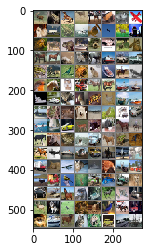

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

I have defined the CNN model C1-C2-C3-C4 defined in model.py and Net is main class which defines teh model. Dilated kernel is used in first layer of C1 and depthwise kernel is used in first layer of C3. Final RF is 122



In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        Dropout2d-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

/content/model.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 25 epochs to train the model

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



In [10]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch, train_losses,train_acc )
    test(model, device, testloader, test_losses, test_acc)
    scheduler.step()

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


/content/model.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=3.0993175506591797 Batch_id=390 Accuracy=45.47: 100%|██████████| 391/391 [00:18<00:00, 21.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1598, Accuracy: 5830/10000 (58.30%)

EPOCH: 1


Loss=2.338263750076294 Batch_id=390 Accuracy=59.94: 100%|██████████| 391/391 [00:18<00:00, 21.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1825, Accuracy: 5813/10000 (58.13%)

EPOCH: 2


Loss=2.075066566467285 Batch_id=390 Accuracy=63.34: 100%|██████████| 391/391 [00:18<00:00, 22.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0150, Accuracy: 6443/10000 (64.43%)

EPOCH: 3


Loss=1.9200961589813232 Batch_id=390 Accuracy=65.59: 100%|██████████| 391/391 [00:18<00:00, 21.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0760, Accuracy: 6260/10000 (62.60%)

EPOCH: 4


Loss=1.8132764101028442 Batch_id=390 Accuracy=66.88: 100%|██████████| 391/391 [00:18<00:00, 21.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9558, Accuracy: 6677/10000 (66.77%)

EPOCH: 5


Loss=1.925611138343811 Batch_id=390 Accuracy=68.00: 100%|██████████| 391/391 [00:18<00:00, 21.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9954, Accuracy: 6538/10000 (65.38%)

EPOCH: 6


Loss=1.3925871849060059 Batch_id=390 Accuracy=76.57: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5961, Accuracy: 7977/10000 (79.77%)

EPOCH: 7


Loss=1.3910529613494873 Batch_id=390 Accuracy=79.19: 100%|██████████| 391/391 [00:18<00:00, 21.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5908, Accuracy: 7952/10000 (79.52%)

EPOCH: 8


Loss=1.0594148635864258 Batch_id=390 Accuracy=79.87: 100%|██████████| 391/391 [00:18<00:00, 22.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5776, Accuracy: 8019/10000 (80.19%)

EPOCH: 9


Loss=1.126666784286499 Batch_id=390 Accuracy=80.05: 100%|██████████| 391/391 [00:17<00:00, 22.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5826, Accuracy: 8040/10000 (80.40%)

EPOCH: 10


Loss=1.117760181427002 Batch_id=390 Accuracy=80.21: 100%|██████████| 391/391 [00:18<00:00, 22.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5775, Accuracy: 8034/10000 (80.34%)

EPOCH: 11


Loss=1.2313487529754639 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5668, Accuracy: 8056/10000 (80.56%)

EPOCH: 12


Loss=0.9950528740882874 Batch_id=390 Accuracy=84.18: 100%|██████████| 391/391 [00:18<00:00, 21.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4833, Accuracy: 8339/10000 (83.39%)

EPOCH: 13


Loss=1.106369972229004 Batch_id=390 Accuracy=85.42: 100%|██████████| 391/391 [00:18<00:00, 22.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4761, Accuracy: 8386/10000 (83.86%)

EPOCH: 14


Loss=1.1093295812606812 Batch_id=390 Accuracy=85.63: 100%|██████████| 391/391 [00:18<00:00, 21.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4708, Accuracy: 8391/10000 (83.91%)

EPOCH: 15


Loss=0.8309308886528015 Batch_id=390 Accuracy=86.19: 100%|██████████| 391/391 [00:18<00:00, 22.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4683, Accuracy: 8409/10000 (84.09%)

EPOCH: 16


Loss=0.9945316910743713 Batch_id=390 Accuracy=86.23: 100%|██████████| 391/391 [00:18<00:00, 22.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4734, Accuracy: 8411/10000 (84.11%)

EPOCH: 17


Loss=0.8507850170135498 Batch_id=390 Accuracy=86.59: 100%|██████████| 391/391 [00:18<00:00, 22.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4701, Accuracy: 8408/10000 (84.08%)

EPOCH: 18


Loss=0.9178498387336731 Batch_id=390 Accuracy=87.40: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4645, Accuracy: 8445/10000 (84.45%)

EPOCH: 19


Loss=1.0169169902801514 Batch_id=390 Accuracy=87.34: 100%|██████████| 391/391 [00:18<00:00, 21.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4627, Accuracy: 8446/10000 (84.46%)

EPOCH: 20


Loss=0.8140555620193481 Batch_id=390 Accuracy=87.45: 100%|██████████| 391/391 [00:18<00:00, 22.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4626, Accuracy: 8447/10000 (84.47%)

EPOCH: 21


Loss=0.9583560228347778 Batch_id=390 Accuracy=87.46: 100%|██████████| 391/391 [00:18<00:00, 21.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4633, Accuracy: 8445/10000 (84.45%)

EPOCH: 22


Loss=0.967059850692749 Batch_id=390 Accuracy=87.41: 100%|██████████| 391/391 [00:18<00:00, 21.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4629, Accuracy: 8453/10000 (84.53%)

EPOCH: 23


Loss=1.009822964668274 Batch_id=390 Accuracy=87.65: 100%|██████████| 391/391 [00:18<00:00, 21.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4617, Accuracy: 8446/10000 (84.46%)

EPOCH: 24


Loss=0.896560549736023 Batch_id=390 Accuracy=87.81: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s]



Test set: Average loss: 0.4606, Accuracy: 8447/10000 (84.47%)



## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



GroundTruth:    cat  ship  ship plane


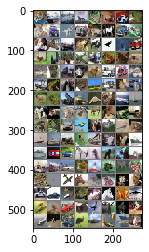

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/model.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [14]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/content/model.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the network on the 10000 test images: 84.47 %


The accuracy 84.47 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [15]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/model.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of plane : 79 %
Accuracy of   car : 100 %
Accuracy of  bird : 69 %
Accuracy of   cat : 64 %
Accuracy of  deer : 85 %
Accuracy of   dog : 72 %
Accuracy of  frog : 86 %
Accuracy of horse : 84 %
Accuracy of  ship : 96 %
Accuracy of truck : 89 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Loss
ii. Training Accuracy
iii. Test Loss
iv. Test Accuracy

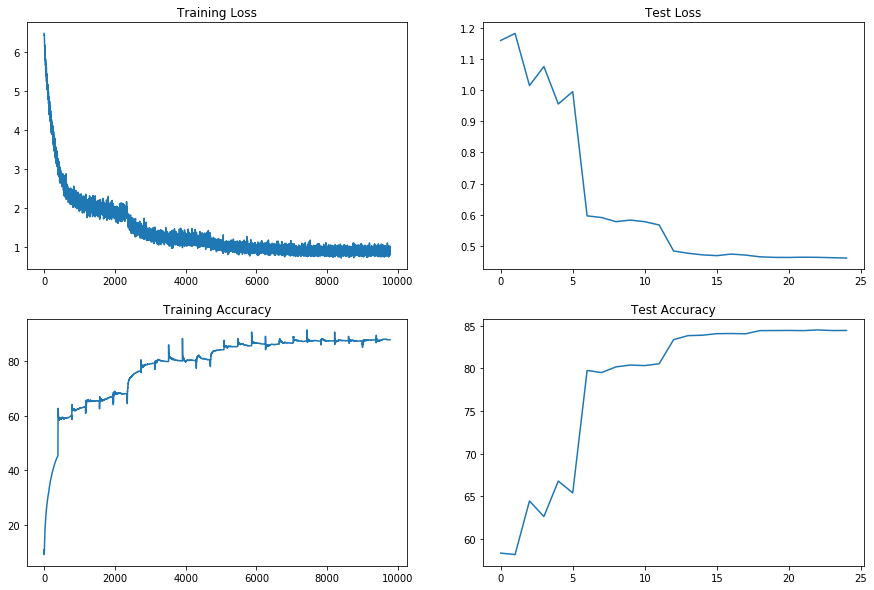

In [16]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)